In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile

CHUNK_SIZE = 40960

# Kaggle数据源映射，用于下载和解压数据
DATA_SOURCE_MAPPING = 'covid19-radiography-database:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F576013%2F3324348%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240102%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240102T080523Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5b97c60d550b5b82ff40b2d6c188f6d5e53ce4f1d028f9284e0dec0d2120552eceb9c26521306bae25d3e03d1ae2b6da622eca16a4ba04fe6b6ac2d3ef0775169a4a147debab043071732cfa8cee44ee5d71586fb9f9a24d8fbb9ddd68372ae39eb4cb120f49eb9b68b1199a47e718e8d6c44ad7c158c2a1f6f81f9f9350cc4989571473943e6e89dc20b4eefea790d9422d7f7cce73b99578a1c718d1578735dcf199392ba3a825348dd8e63c95d7377c76eac02ffdde300245a4828474938f03f972dd528923b55e76be2c2eb5f1ff1d9a55cfa0bd633bb32030bf271d7a4fe2c05cd0dddbd7c7c1c913ec13c6fe078b6ba50bef236cb55b288c2599c284ba'
KAGGLE_INPUT_PATH = 'kaggle/input'
KAGGLE_WORKING_PATH = 'kaggle/working'
KAGGLE_SYMLINK = 'kaggle'

# 创建必要的目录
os.makedirs(KAGGLE_SYMLINK)
os.makedirs(KAGGLE_INPUT_PATH, 0o777)
os.makedirs(KAGGLE_WORKING_PATH, 0o777)

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        # 从URL下载数据
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'下载 {directory}, {total_length} 字节压缩数据')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} 字节已下载")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            # 解压缩下载的文件
            if filename.endswith('.zip'):
                with ZipFile(tfile) as zfile:
                    zfile.extractall(destination_path)
            else:
                with tarfile.open(tfile.name) as tarfile:
                    tarfile.extractall(destination_path)
            print(f'\n已下载并解压: {directory}')
    except HTTPError as e:
        print(f'无法加载（可能已过期） {download_url} 到路径 {destination_path}')
        continue
    except OSError as e:
        print(f'无法加载 {download_url} 到路径 {destination_path}')
        continue

print('数据源导入完成。')

下载 covid19-radiography-database, 816029038 字节压缩数据
[==================================================] 816029038 字节已下载
已下载并解压: covid19-radiography-database
数据源导入完成。


In [3]:
!pip install tensorflow

In [4]:
# 导入系统库
import os
import time
import shutil
import pathlib
import itertools

# 导入数据处理工具
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# 导入深度学习库
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense,
                                     Activation, Dropout, BatchNormalization)
from tensorflow.keras import regularizers

# 忽略警告
import warnings
warnings.filterwarnings("ignore")

# 打印加载模块完成的消息
print('模块加载完成')


模块加载完成


In [6]:
# 定义数据路径和标签
def define_paths(data_dir):
    filepaths = []
    labels = []

    # 遍历主目录下的所有文件夹
    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        # 如果不是文件夹，则忽略
        if pathlib.Path(foldpath).suffix != '':
            continue

        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)

            # 检查是否为文件夹
            if pathlib.Path(foldpath).suffix == '':
                # 忽略不需要的masks文件夹
                if pathlib.Path(fpath).parts[-1] in ['masks', 'Masks', 'MASKS']:
                    continue
                else:
                    o_file = os.listdir(fpath)
                    for f in o_file:
                        ipath = os.path.join(fpath, f)
                        filepaths.append(ipath)
                        labels.append(fold)
            else:
                filepaths.append(fpath)
                labels.append(fold)

    return filepaths, labels

# 将数据路径和标签合并成一个DataFrame
def define_df(files, classes):
    Fseries = pd.Series(files, name='filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis=1)

# 分割数据为训练集、验证集和测试集
def split_data(data_dir):
    # 生成训练DataFrame
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)

    # 生成验证集和测试集DataFrame
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)

    return train_df, valid_df, test_df


In [7]:
def create_gens(train_df, valid_df, test_df, batch_size):
    '''
    此函数接受训练集、验证集和测试集的DataFrame，并将它们适配到图像数据生成器中，因为模型需要从图像数据生成器中获取数据。
    图像数据生成器将图像转换为张量。
    '''

    # 定义模型参数
    img_size = (224, 224)
    channels = 3  # 彩色图片 (BGR) 或灰度图像
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # 推荐：对测试数据使用自定义的批量大小，否则可以使用常规批量大小
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1)
                                  if ts_length % n == 0 and ts_length / n <= 80]))
    test_steps = ts_length // test_batch_size

    # 这个函数将用于图像数据生成器的数据增强，它只是接收图像并原样返回
    def scalar(img):
        return img

    # 创建训练和测试图像数据生成器
    tr_gen = ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
    ts_gen = ImageDataGenerator(preprocessing_function=scalar)

    # 从DataFrame创建训练、验证和测试生成器
    train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                           target_size=img_size, class_mode='categorical',
                                           color_mode=color, shuffle=True, batch_size=batch_size)

    valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',
                                           target_size=img_size, class_mode='categorical',
                                           color_mode=color, shuffle=True, batch_size=batch_size)

    # 注意：在测试生成器中使用自定义的test_batch_size，并设置shuffle=False
    test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                          target_size=img_size, class_mode='categorical',
                                          color_mode=color, shuffle=False, batch_size=test_batch_size)

    return train_gen, valid_gen, test_gen

In [8]:
def show_images(gen):
    '''
    此函数接收数据生成器并展示样本图像。
    '''

    # 获取类别和待显示的图像
    g_dict = gen.class_indices        # 定义字典 {'class': index}
    classes = list(g_dict.keys())     # 获取字典键（类别）的列表，即类别名称：字符串
    images, labels = next(gen)        # 从生成器获取一批样本图像和标签

    # 计算展示样本的数量
    length = len(labels)              # 批量大小的长度
    sample = min(length, 25)          # 检查样本是否少于25张图像

    plt.figure(figsize=(20, 20))      # 设置图像显示的大小

    for i in range(sample):
        plt.subplot(5, 5, i + 1)      # 创建子图
        image = images[i] / 255       # 将数据缩放到0-255范围
        plt.imshow(image)             # 显示图像
        index = np.argmax(labels[i])  # 获取图像的索引
        class_name = classes[index]   # 获取图像对应的类别
        plt.title(class_name, color='blue', fontsize=12)  # 设置标题
        plt.axis('off')               # 关闭坐标轴

    plt.show()                         # 显示所有子图


In [9]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights)


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch

            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer

                else:
                    self.count = self.count + 1 # increment the patience counter

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1:
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)

                        except Exception:
                            print('Invalid')

In [10]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

In [11]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	'''
	This function plot confusion matrix method from sklearn package.
	'''

	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

In [13]:
data_dir = '/content/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset'

try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(data_dir)

    # Get Generators
    batch_size = 16
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except:
    print('Invalid Input')

Found 16932 validated image filenames belonging to 4 classes.
Found 2116 validated image filenames belonging to 4 classes.
Found 2117 validated image filenames belonging to 4 classes.


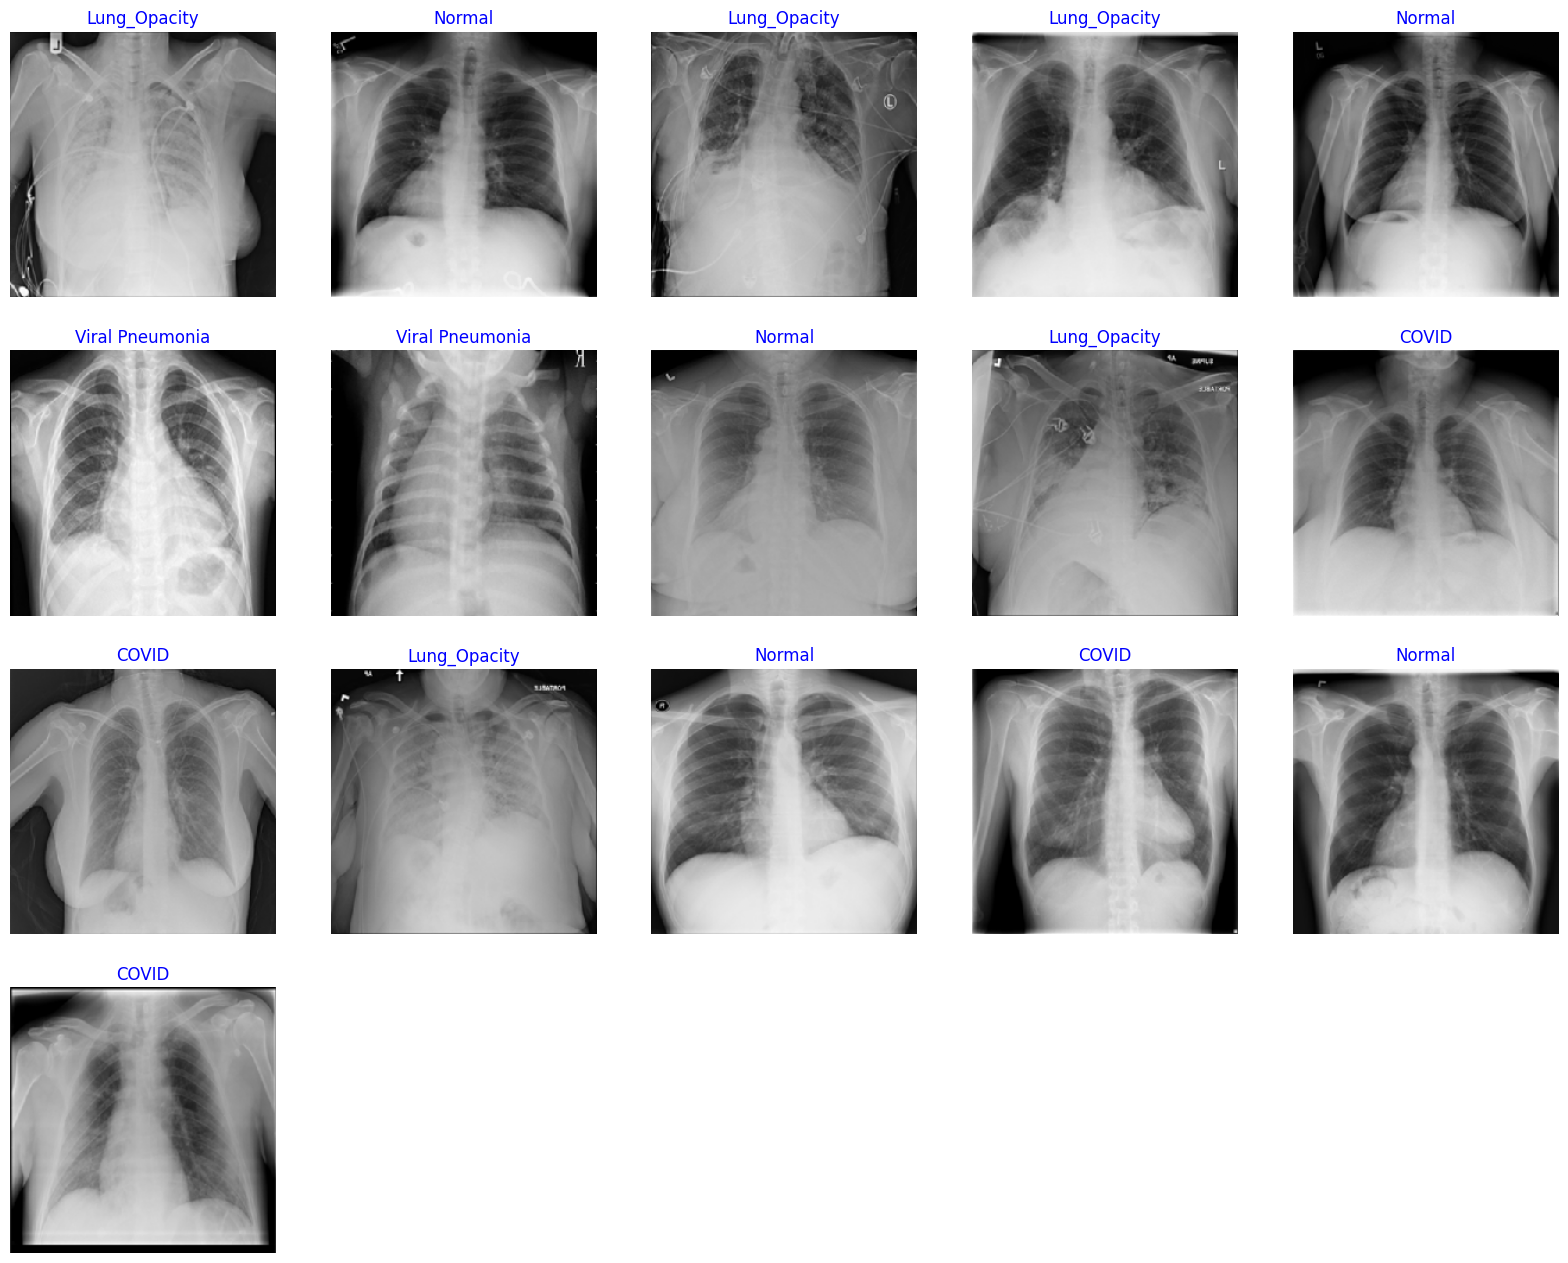

In [14]:
show_images(train_gen)

In [20]:
# 创建模型结构
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))  # 根据训练数据生成器中的类别数量定义Dense层的输出节点数

# 创建预训练模型（使用MobileNet）#我使用了restnet50，但是参数太大了
base_model = tf.keras.applications.MobileNet(
    include_top=False,
    weights="imagenet",
    input_shape=img_shape,
    pooling='max'
)

# 构建序贯模型
model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

# 编译模型
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 打印模型摘要
model.summary()



17225924/17225924 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 1024)             3228864   
 nal)                                                            
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                       

In [23]:
batch_size = 32   # 增加批量大小以加快训练
epochs = 1   # 维持1个epoch
# 其余的回调函数参数在只有1个epoch的情况下不会产生影响
patience = 3
stop_patience = 10
threshold = 0.9
factor = 0.5
ask_epoch = 5

batches = int(np.ceil(len(train_gen.labels) / batch_size))  # 根据新的批量大小计算批次数

callbacks = [MyCallback(model=model, patience=patience, stop_patience=stop_patience,
                        threshold=threshold, factor=factor, batches=batches,
                        epochs=epochs, ask_epoch=ask_epoch)]

In [24]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

Do you want model asks you to halt the training [y/n] ?
y
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /1      3.780   85.548   1.63545  86.720   0.00100  0.00100  accuracy     0.00   3644.73 
training elapsed time was 1.0 hours,  0.0 minutes, 44.79 seconds)


In [26]:
# 计算测试数据集的长度
ts_length = len(test_df)
# 计算测试批量大小。这里选择最大的批量大小，但保证每批的样本数不超过80
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
# 计算测试时的步骤数
test_steps = ts_length // test_batch_size

# 在训练集上评估模型
train_score = model.evaluate(train_gen, steps=test_steps, verbose=1)
# 在验证集上评估模型
valid_score = model.evaluate(valid_gen, steps=test_steps, verbose=1)
# 在测试集上评估模型
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)

# 打印训练集的损失和准确率
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
# 打印验证集的损失和准确率
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
# 打印测试集的损失和准确率
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

29/29 [==============================] - 111s 4s/step - loss: 1.6244 - accuracy: 0.8701
Train Loss:  1.6452089548110962
Train Accuracy:  0.8706896305084229
--------------------
Validation Loss:  1.6188287734985352
Validation Accuracy:  0.8771551847457886
--------------------
Test Loss:  1.6244319677352905
Test Accuracy:  0.8700991868972778


[1 2 0 ... 2 2 2]
Confusion Matrix, Without Normalization
[[356   1   4   1]
 [ 26 538  38   0]
 [ 47  85 816  71]
 [  2   0   0 132]]
                 precision    recall  f1-score   support

          COVID       0.83      0.98      0.90       362
   Lung_Opacity       0.86      0.89      0.88       602
         Normal       0.95      0.80      0.87      1019
Viral Pneumonia       0.65      0.99      0.78       134

       accuracy                           0.87      2117
      macro avg       0.82      0.92      0.86      2117
   weighted avg       0.89      0.87      0.87      2117



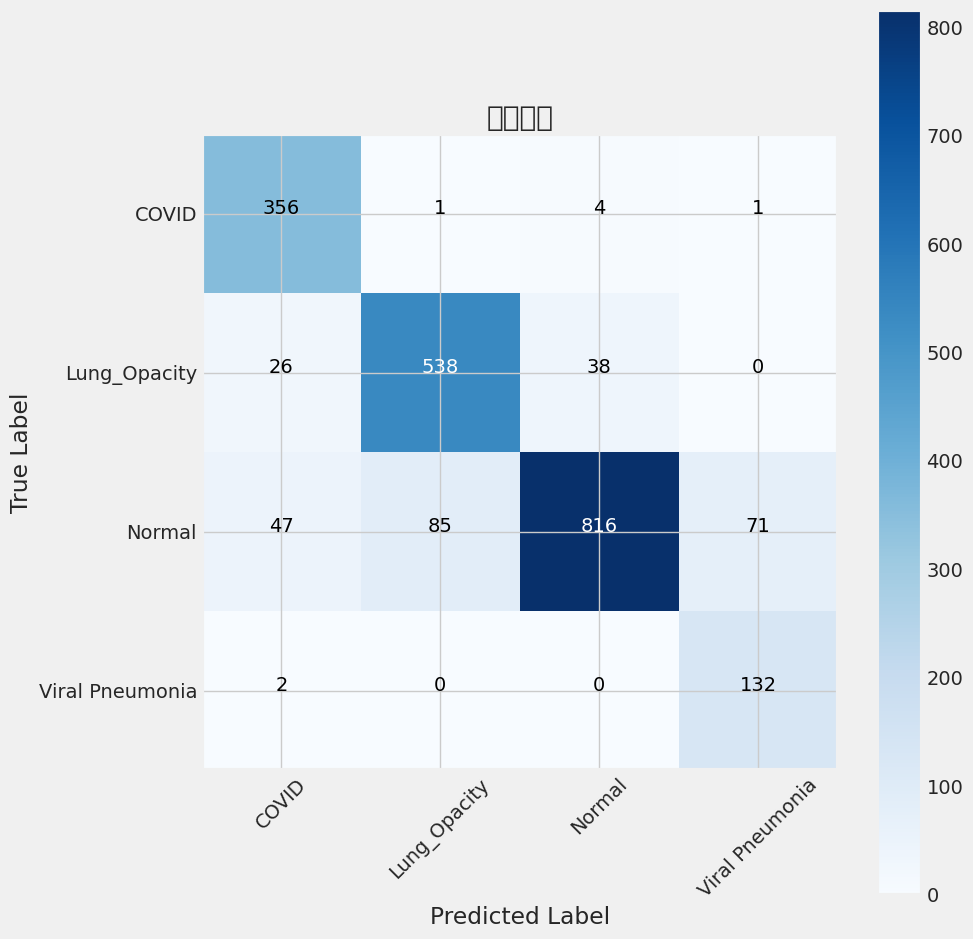

In [28]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

# 获取测试生成器的类别索引字典
g_dict = test_gen.class_indices
# 提取所有类别的名称
classes = list(g_dict.keys())

# 计算混淆矩阵
cm = confusion_matrix(test_gen.classes, y_pred)
# 绘制混淆矩阵
plot_confusion_matrix(cm=cm, classes=classes, title='混淆矩阵')

# 输出分类报告
print(classification_report(test_gen.classes, y_pred, target_names=classes))

In [29]:
# 获取模型名称
model_name = model.input_names[0][:-6]
subject = 'Yifan Yang_chest'  # 定义主题或标签
acc = test_score[1] * 100  # 将测试精度转换为百分比
save_path = ''  # 指定保存路径，如果为空字符串，则保存在当前目录

# 保存模型
# 创建保存模型的文件名，包含模型名称、主题和精度
save_id = str(f'{model_name}-{subject}-{"%.2f" % round(acc, 2)}.h5')
# 定义完整的保存路径
model_save_loc = os.path.join(save_path, save_id)
# 保存模型到指定路径
model.save(model_save_loc)
# 打印模型保存位置
print(f'模型已保存至 {model_save_loc}')

# 保存模型权重
# 创建保存模型权重的文件名
weight_save_id = str(f'{model_name}-{subject}-weights.h5')
# 定义权重的完整保存路径
weights_save_loc = os.path.join(save_path, weight_save_id)
# 保存模型权重到指定路径
model.save_weights(weights_save_loc)
# 打印权重保存位置
print(f'模型权重已保存至 {weights_save_loc}')

模型已保存至 mobilenet_1.00_224-Yifan Yang_chest-87.01.h5
模型权重已保存至 mobilenet_1.00_224-Yifan Yang_chest-weights.h5
